### Policy Evaluation and Comparison


In [2]:
import ai4rgym
from ai4rgym.envs.road import Road
import gymnasium as gym
import numpy as np
import random
from stable_baselines3 import PPO, SAC, DDPG
from policies.rl_policy import RLPolicy
from evaluation.evaluation_for_autonomous_driving import simulate_policy
from evaluation.evaluation_for_autonomous_driving import plot_results_from_time_series_dict

from utils import ensure_dir, ensure_dirs, eval_model
import matplotlib.pyplot as plt

#### Environment Settings

In [3]:
# SPECIFY THE ROAD

# This road will not be used for training / evaluation
# this is just kept in place to initialize the environment
road_elements_list = [
    {"type":"straight", "length":100.0},
    {"type":"curved", "curvature":1/800.0, "angle_in_degrees":15.0},
    {"type":"straight", "length":100.0},
    {"type":"curved", "curvature":-1/400.0, "angle_in_degrees":30.0},
    {"type":"straight", "length":100.0},
]

# SPECIFY THE NUMERICAL INTEGRATION DETAILS
numerical_integration_parameters = {
    "method" : "rk4",
    "Ts" : 0.05,
    "num_steps_per_Ts" : 1,
}

# SPECIFY THE INITIAL STATE DISTRIBUTION

py_init_min = -1.0
py_init_max =  1.0

v_init_min_in_kmh = 55.0
v_init_max_in_kmh = 65.0

py_init_min = -1.0
py_init_max =  1.0

v_init_min_in_kmh = 55.0
v_init_max_in_kmh = 65.0

initial_state_bounds = {
    "px_init_min" : 0.0,
    "px_init_max" : 0.0,
    "py_init_min" : py_init_min,
    "py_init_max" : py_init_max,
    "theta_init_min" : 0.0,
    "theta_init_max" : 0.0,
    "vx_init_min" : v_init_min_in_kmh * (1.0/3.6),
    "vx_init_max" : v_init_max_in_kmh * (1.0/3.6),
    "vy_init_min" : 0.0,
    "vy_init_max" : 0.0,
    "omega_init_min" : 0.0,
    "omega_init_max" : 0.0,
    "delta_init_min" : 0.0,
    "delta_init_max" : 0.0,
}

# SPECIFY THE TERMINATION PARAMETERS
termination_parameters = {
    "speed_lower_bound"  :  (20.0/3.6),            # to maintain speed above 20 km/h 
    "speed_upper_bound"  :  (200.0/3.6),
    "distance_to_closest_point_upper_bound"  : 10.0,
    "reward_speed_lower_bound"  :  -5000.0,
    "reward_speed_upper_bound"  :  -2000.0,
    "reward_distance_to_closest_point_upper_bound"  :  -5000.0,
}


# SPECIFY THE OBSERVATION PARAMETERS
observation_parameters_PPO = {
    "should_include_ground_truth_px"                       :  "info",
    "should_include_ground_truth_py"                       :  "info",
    "should_include_ground_truth_theta"                    :  "info",
    "should_include_ground_truth_vx"                       :  "info",
    "should_include_ground_truth_vy"                       :  "info",
    "should_include_ground_truth_omega"                    :  "info",
    "should_include_ground_truth_delta"                    :  "info",
    "should_include_road_progress_at_closest_point"        :  "info",
    "should_include_vx_sensor"                             :  "obs",
    "should_include_distance_to_closest_point"             :  "obs",
    "should_include_heading_angle_relative_to_line"        :  "obs",
    "should_include_heading_angular_rate_gyro"             :  "info", # "obs",
    "should_include_closest_point_coords_in_body_frame"    :  "info",
    "should_include_look_ahead_line_coords_in_body_frame"  :  "info",
    "should_include_road_curvature_at_closest_point"       :  "obs",
    "should_include_look_ahead_road_curvatures"            :  "info", # "obs",

    "scaling_for_ground_truth_px"                       :  1.0,
    "scaling_for_ground_truth_py"                       :  1.0,
    "scaling_for_ground_truth_theta"                    :  1.0,
    "scaling_for_ground_truth_vx"                       :  1.0,
    "scaling_for_ground_truth_vy"                       :  1.0,
    "scaling_for_ground_truth_omega"                    :  1.0,
    "scaling_for_ground_truth_delta"                    :  1.0,
    "scaling_for_road_progress_at_closest_point"        :  1.0,
    "scaling_for_vx_sensor"                             :  1.0,
    "scaling_for_distance_to_closest_point"             :  1.0,
    "scaling_for_heading_angle_relative_to_line"        :  1.0,
    "scaling_for_heading_angular_rate_gyro"             :  1.0,
    "scaling_for_closest_point_coords_in_body_frame"    :  1.0,
    "scaling_for_look_ahead_line_coords_in_body_frame"  :  1.0,
    "scaling_for_road_curvature_at_closest_point"       :  1.0,
    "scaling_for_look_ahead_road_curvatures"            :  1.0,

    "vx_sensor_bias"    : 0.0,
    "vx_sensor_stddev"  : 0.1,

    "distance_to_closest_point_bias"    :  0.0,
    "distance_to_closest_point_stddev"  :  0.01,

    "heading_angle_relative_to_line_bias"    :  0.0,
    "heading_angle_relative_to_line_stddev"  :  0.01,

    "heading_angular_rate_gyro_bias"    :  0.0,
    "heading_angular_rate_gyro_stddev"  :  0.01,

    "closest_point_coords_in_body_frame_bias"    :  0.0,
    "closest_point_coords_in_body_frame_stddev"  :  0.0,

    "look_ahead_line_coords_in_body_frame_bias"    :  0.0,
    "look_ahead_line_coords_in_body_frame_stddev"  :  0.0,

    "road_curvature_at_closest_point_bias"    :  0.0,
    "road_curvature_at_closest_point_stddev"  :  0.0,

    "look_ahead_road_curvatures_bias"    :  0.0,
    "look_ahead_road_curvatures_stddev"  :  0.0,

    "look_ahead_line_coords_in_body_frame_distance"    :  100.0,
    "look_ahead_line_coords_in_body_frame_num_points"  :  10,
}

observation_parameters_SAC = {
    "should_include_ground_truth_px"                       :  "info",
    "should_include_ground_truth_py"                       :  "info",
    "should_include_ground_truth_theta"                    :  "info",
    "should_include_ground_truth_vx"                       :  "info",
    "should_include_ground_truth_vy"                       :  "info",
    "should_include_ground_truth_omega"                    :  "info",
    "should_include_ground_truth_delta"                    :  "info",
    "should_include_road_progress_at_closest_point"        :  "info",
    "should_include_vx_sensor"                             :  "obs",
    "should_include_distance_to_closest_point"             :  "obs",
    "should_include_heading_angle_relative_to_line"        :  "obs",
    "should_include_heading_angular_rate_gyro"             :  "obs",
    "should_include_closest_point_coords_in_body_frame"    :  "info",
    "should_include_look_ahead_line_coords_in_body_frame"  :  "info",
    "should_include_road_curvature_at_closest_point"       :  "obs",
    "should_include_look_ahead_road_curvatures"            :  "obs",

    "scaling_for_ground_truth_px"                       :  1.0,
    "scaling_for_ground_truth_py"                       :  1.0,
    "scaling_for_ground_truth_theta"                    :  1.0,
    "scaling_for_ground_truth_vx"                       :  1.0,
    "scaling_for_ground_truth_vy"                       :  1.0,
    "scaling_for_ground_truth_omega"                    :  1.0,
    "scaling_for_ground_truth_delta"                    :  1.0,
    "scaling_for_road_progress_at_closest_point"        :  1.0,
    "scaling_for_vx_sensor"                             :  1.0,
    "scaling_for_distance_to_closest_point"             :  1.0,
    "scaling_for_heading_angle_relative_to_line"        :  1.0,
    "scaling_for_heading_angular_rate_gyro"             :  1.0,
    "scaling_for_closest_point_coords_in_body_frame"    :  1.0,
    "scaling_for_look_ahead_line_coords_in_body_frame"  :  1.0,
    "scaling_for_road_curvature_at_closest_point"       :  1.0,
    "scaling_for_look_ahead_road_curvatures"            :  1.0,

    "vx_sensor_bias"    : 0.0,
    "vx_sensor_stddev"  : 0.1,

    "distance_to_closest_point_bias"    :  0.0,
    "distance_to_closest_point_stddev"  :  0.01,

    "heading_angle_relative_to_line_bias"    :  0.0,
    "heading_angle_relative_to_line_stddev"  :  0.01,

    "heading_angular_rate_gyro_bias"    :  0.0,
    "heading_angular_rate_gyro_stddev"  :  0.01,

    "closest_point_coords_in_body_frame_bias"    :  0.0,
    "closest_point_coords_in_body_frame_stddev"  :  0.0,

    "look_ahead_line_coords_in_body_frame_bias"    :  0.0,
    "look_ahead_line_coords_in_body_frame_stddev"  :  0.0,

    "road_curvature_at_closest_point_bias"    :  0.0,
    "road_curvature_at_closest_point_stddev"  :  0.0,

    "look_ahead_road_curvatures_bias"    :  0.0,
    "look_ahead_road_curvatures_stddev"  :  0.0,

    "look_ahead_line_coords_in_body_frame_distance"    :  100.0,
    "look_ahead_line_coords_in_body_frame_num_points"  :  10,
}


In [4]:
SPEED_LIMIT_KMH = 100.0
SPEED_LIMIT = SPEED_LIMIT_KMH / 3.6 # 100 km/h

In [5]:
class RewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(RewardWrapper, self).__init__(env)
        self.previous_progress_at_closest_point = None
        self.previous_heading_angular_rate_gyro = None
        self.previous_heading_angle = None

        # set speed limit
        SPEED_LIMIT = 100.0 / 3.6 # 100 km/h
        self.speed_limit = SPEED_LIMIT 
        
        # constants chosen so that the maximum reward obtained from road proximity and speed are the same order of magnitude (i.e. normalized)
        self.progress_reward_constant = 1.0 
        self.road_proximity_reward_constant_1 = 1.0 
        self.road_proximity_reward_constant_2 = 2.0 
        self.speed_reward_constant = 4.0 
        self.heading_reward_constant_1 = 2.0    
        self.heading_reward_constant_2 = 0.16 # 0.15
        self.angular_velocity_smoothness_reward_constant = 0.20 
        self.high_road_curvature_threshold = 1/250.0 

    def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)

        ###############################################    
        # Custom reward, overwrite the default reward
        ###############################################    
        reward = 0.0 # overwrite default reward

        # set progress reward
        progress_at_closest_point = info["road_progress_at_closest_point"]
        if self.previous_progress_at_closest_point is not None:
            progress_reward = (progress_at_closest_point - self.previous_progress_at_closest_point) * self.progress_reward_constant
        else:
            progress_reward = 0.0
        self.previous_progress_at_closest_point = progress_at_closest_point


        # give higher progress reward for progress closer to the end of the road, to encourage reaching the destination faster
        # also don't give positive road proximity reward if the vehicle is not progressing

        # set road proximity reward, i.e. how close the vehicle is to the road
        #  positive reward if close to the road i.e. within 2m
        #  negative reward if far from the road i.e. more than 2m
        d = abs(observation["distance_to_closest_point"])
        
        road_proximity_reward = 0.0
        if d < 0.5:
            if progress_reward > 0.0:
                road_proximity_reward = 3.5 * self.road_proximity_reward_constant_1 * (1.0 - d**2)

        elif 0.5 <= d < 2.0:
            if progress_reward > 0.0:
                road_proximity_reward = self.road_proximity_reward_constant_1 * (2.0 - d)**2
        else:
            road_proximity_reward = -self.road_proximity_reward_constant_2 * np.tanh((d - 2.0)**4)


        # set speed reward 
        # positive reward if speed is less than speed limit, otherwise negative reward
        # positive reward also reduced in proportion to max look ahead road curvature in the next 3 points 
        vx = abs(observation["vx_sensor"])
        road_curvature_closest_point = max(np.abs(observation["look_ahead_road_curvatures"][:3]))   
    
        # road curvature multiplier to encourage slower speeds on high curvature roads
        if road_curvature_closest_point >= self.high_road_curvature_threshold:
            road_curvature_multiplier = 1.0 /  (1.0 + (400.0*(road_curvature_closest_point - self.high_road_curvature_threshold)**(1.5)))
        else:
            road_curvature_multiplier = 1.0    

        # adaptive speed limit based on road curvature, lower speed limit for higher curvature roads
        adjusted_speed_limit = self.speed_limit * road_curvature_multiplier

        # piecewise linear below speed limit (to encourage driving at a speed closer to the adjusted speed limit)
        if vx < 0.9*adjusted_speed_limit:
            speed_reward =  self.speed_reward_constant * (vx / (0.9*adjusted_speed_limit))**2 

        elif 0.9*adjusted_speed_limit <= vx < adjusted_speed_limit:
            speed_reward =  -self.speed_reward_constant * (vx - adjusted_speed_limit) / (0.1*adjusted_speed_limit)

        else:
            #speed_reward = -self.speed_reward_constant * np.tanh((vx - adjusted_speed_limit)**4)
            #speed_reward = self.speed_reward_constant * ( (1.0/((vx - adjusted_speed_limit+ 1)**4)) - 1.0)
            speed_reward = 0.5 *self.speed_reward_constant * ( (1.0/((vx - adjusted_speed_limit+ 1)**4)) - 1.0)


        # set reward for maintaining small heading angle relative to the line (negative reward proportional to the heading angle)
        # for heading angle smaller than 2 degrees, give positive reward, otherwise give negative reward
        heading_angle_degrees = abs(observation["heading_angle_relative_to_line"]) * 180.0 / np.pi 
        heading_reward = 0.0
        if heading_angle_degrees < 1.0:
            # give positive heading reward only if there is progress
            if progress_reward > 0.0: 
                heading_reward = self.heading_reward_constant_1 * (heading_angle_degrees-1.0)**2 / 4.0
        else:
            heading_reward = -self.heading_reward_constant_2 * abs(heading_angle_degrees)

        # set reward for encouraging smoother steering, by penalize large gradients in heading angle and angular velocity
        if self.previous_heading_angle is not None:
            heading_angle = abs(observation["heading_angle_relative_to_line"])
            heading_angle_change_degrees = abs(heading_angle - self.previous_heading_angle) * 180.0 / np.pi
            angular_velocity_smoothness_reward = -self.angular_velocity_smoothness_reward_constant * heading_angle_change_degrees
        else:
            angular_velocity_smoothness_reward = 0.0
         

        # TODO: check termination condition and set termination rewards
        terminated = False
        termination_reward = 0.0
        if (progress_at_closest_point >= self.env.unwrapped.total_road_length_for_termination):
            #print("(prog,tot_len) = ( " + str(info_dict["progress_at_closest_p"]) + " , " + str(self.total_road_length) + " )" )
            terminated = True
        # > Terminate for being outside of the speed range
        if (vx > self.env.unwrapped.termination_speed_upper_bound):
            terminated = True
            termination_reward += self.env.unwrapped.termination_reward_for_speed_upper_bound
        if (observation["vx_sensor"] < self.env.unwrapped.termination_speed_lower_bound):
            terminated = True
            termination_reward += self.env.unwrapped.termination_reward_for_speed_lower_bound
        # > Terminate for deviating too much from the line
        if (d > self.env.unwrapped.termination_distance_to_closest_point_upper_bound):
            terminated = True
            termination_reward += self.env.unwrapped.termination_reward_for_distance_to_closest_point_upper_bound

        # no truncation
        truncated = False

        # add up all the reward contributions (ignore speed reward for now)
        reward = progress_reward + road_proximity_reward + speed_reward + heading_reward + angular_velocity_smoothness_reward + termination_reward

        return observation, reward, terminated, truncated, info




# use default reward wrapper to avoid episode termination
class RewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(RewardWrapper, self).__init__(env)

    def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)

        # Create your own reward here
        reward = reward

        return observation, reward, terminated, truncated, info
    


def create_env(road_elements_list, model, delta_offset_multiplier=0.0, mass_multiplier=1.0):
    if model == "PPO":
        observation_parameters = observation_parameters_PPO
    elif model == "SAC":
        observation_parameters = observation_parameters_SAC

    # SPECIFY THE VEHCILE PARAMETERS
    bicycle_model_parameters = {
        "Lf" : 0.55*2.875,
        "Lr" : 0.45*2.875,
        "m"  : mass_multiplier * 2000.0,
        "Iz" : (1.0/12.0) * 2000.0 * (4.692**2+1.850**2),
        "Cm" : (1.0/100.0) * (1.0 * 400.0 * 9.0) / 0.2286,
        "Cd" : 0.5 * 0.24 * 2.2204 * 1.202,
        "delta_offset" : delta_offset_multiplier * np.pi/180,
        "delta_request_max" : 45 * np.pi/180,
        "Ddelta_lower_limit" : -45 * np.pi/180,
        "Ddelta_upper_limit" :  45 * np.pi/180,
        "v_transition_min": 3.0,    # v_transition_min = 3.0 m/s
        "v_transition_max": 5.0,    # v_transition_max = 5.0 m/s
        "body_len_f" : (0.55*2.875) * 1.5,
        "body_len_r" : (0.45*2.875) * 1.5,
        "body_width" : 2.50,
    }


    env = gym.make(
        "ai4rgym/autonomous_driving_env",
        render_mode=None,
        bicycle_model_parameters=bicycle_model_parameters,
        road_elements_list=road_elements_list,
        numerical_integration_parameters=numerical_integration_parameters,
        termination_parameters=termination_parameters,
        initial_state_bounds=initial_state_bounds,
        observation_parameters=observation_parameters,
    )

    # Set the integration method and time step
    Ts_sim = 0.05
    integration_method = "rk4"
    env.unwrapped.set_integration_method(integration_method)
    env.unwrapped.set_integration_Ts(Ts_sim)

    # Set the road condition
    env.unwrapped.set_road_condition(road_condition="wet")

    # Rescale actions and wrap the environment
    env = gym.wrappers.RescaleAction(env, min_action=-1, max_action=1)
    env = RewardWrapper(env)
    return env


def setup_eval_environment(road_elements_list):

    # Create the evaluation environment with the fixed difficult road
    eval_env = create_env(road_elements_list)

    # Render the road
    eval_env.render_matplotlib_init_figure()
    eval_env.render_matplotlib_plot_road()
    plt.show()

#### Performance Metrics

In [6]:
def compute_performance_metrics_from_time_series(sim_time_series_dict):
    # Compute the statistics of the distance to the line
    # > Note that this is signed value, hence need to take absolute value of the data.
    abs_dist_to_line_time_series = np.abs(sim_time_series_dict["distance_to_closest_point"])
    avg_dist  = np.nanmean(abs_dist_to_line_time_series)
    std_dist  = np.nanstd(abs_dist_to_line_time_series)
    max_dist  = np.nanmax(abs_dist_to_line_time_series)

    # Compute the statistics of the speed in the forward direction (i.e., the body-frame x-axis direction)
    speed_time_series = np.abs(sim_time_series_dict["vx"])
    avg_speed = np.nanmean(speed_time_series)
    std_speed = np.nanstd(speed_time_series)
    max_speed = np.nanmax(speed_time_series)
    min_speed = np.nanmin(speed_time_series)


    ###############################################
    # Speed Limit Metrics
    # -> Maximum speed above speed limit
    # -> Fraction of time spent above speed limit
    ###############################################

    # determine fraction of time steps spent below speed limit, only include time steps which don't have NaN speed
    max_speed = np.nanmax(speed_time_series)
    max_exceedance_speed_limit = max(0, max_speed - SPEED_LIMIT)
    num_time_steps_above_speed_limit = np.sum(speed_time_series > SPEED_LIMIT)
    num_steps_non_NaN = np.sum(~np.isnan(sim_time_series_dict['vx']))
    #num_time_steps = len(speed_time_series)-1
    fraction_time_above_speed_limit = num_time_steps_above_speed_limit / num_steps_non_NaN

    ############################################################################################################
    # Lane Keeping and Smooth Steering Metrics
    # -> Average and Max distance from line
    # -> Fraction of time steps where distance from line is above threshold of 1.0 meters
    # -> Total variation of distance from line
    # -> Max heading angle reached
    # -> Average heading angle deviation
    # -> Total variation of heading angle (want this to be low for smooth steering)
    # -> Fraction of time steps where heading angle is above threshold of 2 degrees
    # Note: total variation is a measure of smoothness, lower value means smoother and less oscillatory steering
    ###########################################################################################################

    distance_from_line_threshold = 1.0
    # determine maximum distance from line
    max_distance_from_line = np.nanmax(abs_dist_to_line_time_series)  
    # determine fraction of time steps where distance from line is above threshold
    num_time_steps_above_distance_from_line_threshold = np.sum(abs_dist_to_line_time_series > distance_from_line_threshold)
    fraction_time_above_distance_from_line_threshold = num_time_steps_above_distance_from_line_threshold / num_steps_non_NaN  

    heading_angle_threshold = 2.0 * np.pi/180
    heading_angle_series = np.abs(sim_time_series_dict["heading_angle_relative_to_line"])
    # determine max heading angle reached
    max_heading_angle = np.nanmax(heading_angle_series)
    # compute average heading angle deviation
    average_heading_angle_deviation_degrees = np.average(heading_angle_series[:num_steps_non_NaN])  * 180.0 / np.pi
    # compute total variation of heading angle (lower tv means smoother and less oscillatory steering)
    total_variation_heading_angle = np.sum(np.abs(np.diff(heading_angle_series[:num_steps_non_NaN])))
    # determine fraction of time steps where heading angle is above threshold
    num_time_steps_above_heading_angle_threshold = np.sum(heading_angle_series > heading_angle_threshold)
    fraction_time_above_heading_angle_threshold = num_time_steps_above_heading_angle_threshold / num_steps_non_NaN


    #######################################
    #  Driving slower around tight corners
    # -> Maximum centripetal acceleration
    # -> Average centripetal acceleration
    # -> Speed at highest curvature
    # -> Maximum slip angle
    #######################################
    
    # derive road radius from road curvature
    road_curvature_series = sim_time_series_dict["road_curvature_at_closest_point"]
    road_radius_series = np.abs(1.0 / road_curvature_series)
    # determine centripetal acceleration (v^2/r)
    centripetal_acceleration_series = (sim_time_series_dict["vx"]**2) / road_radius_series
    # determine maximum centripetal acceleration
    max_centripetal_acceleration = np.nanmax(centripetal_acceleration_series)
    # determine average centripetal acceleration
    avg_centripetal_acceleration = np.nanmean(centripetal_acceleration_series)
    # determine index of largest non-NaN road curvature
    max_curvature_index = np.nanargmax(road_curvature_series)
    # fraction of path corresponding to highest curvature index
    path_fraction_at_highest_curvature = (max_curvature_index+1) / num_steps_non_NaN
    # determine speed at tightest corner
    relative_speed_at_tightest_corner = sim_time_series_dict["vx"][max_curvature_index] / SPEED_LIMIT

    ##################################
    #  Faste Travel-time Metrics
    # -> Total travel time
    # -> Total distance travelled
    ##################################
    total_travel_time = num_steps_non_NaN * numerical_integration_parameters["Ts"]
    total_distance_travelled = np.sum(speed_time_series[:num_steps_non_NaN]) * numerical_integration_parameters["Ts"]


    # Return the results
    return {
        "average_dist_from_line"   :  avg_dist,
        "std_dist"   :  std_dist,
        "max_dist"   :  max_dist,
        "avg_speed"  :  avg_speed * 3.6,
        "std_speed"  :  std_speed * 3.6,
        "max_speed"  :  max_speed * 3.6,
        "min_speed"  :  min_speed * 3.6,
        "max_exceedance_speed_limit" : max_exceedance_speed_limit * 3.6,
        "fraction_time_above_speed_limit" : fraction_time_above_speed_limit,
        "max_distance_from_line" : max_distance_from_line,
        "fraction_time_above_distance_from_line_threshold" : fraction_time_above_distance_from_line_threshold,
        "max_heading_angle_degrees" : max_heading_angle * 180.0 / np.pi,
        "average_heading_angle_deviation_degrees" : average_heading_angle_deviation_degrees,
        "total_variation_heading_angle" : total_variation_heading_angle,
        "fraction_time_heading_angle_exceed_threshold" : fraction_time_above_heading_angle_threshold,
        "max_centripetal_acceleration_magnitude" : max_centripetal_acceleration,
        "avg_centripetal_acceleration_magnitude" : avg_centripetal_acceleration,
        "relative_speed_at_tightest_corner" : relative_speed_at_tightest_corner,
        #"path_fraction_at_highest_curvature" : path_fraction_at_highest_curvature,
        "total_travel_time" : total_travel_time,
    }


### Model Evaluation over a single simulation run

In [7]:
""" 
    Define 3 different evaluation roads
"""

# long straight-ish road
road_elements_list_eval_1 = [
    {"type": "straight", "length": 200.0},
    {"type": "curved", "curvature": 1/5000.0, "angle_in_degrees": 30.0},
    {"type": "straight", "length": 150.0},
    {"type": "curved", "curvature": -1/10000.0, "angle_in_degrees": 10.0},
    {"type": "straight", "length": 150.0},
]


# slightly more challenging road with curves
road_elements_list_eval_2 = [
    {"type": "straight", "length": 50.0},
    {"type": "curved", "curvature": 1/300.0, "angle_in_degrees": 90.0},
    {"type": "straight", "length": 50.0},
    {"type": "curved", "curvature": -1/200.0, "angle_in_degrees": 120.0},
    {"type": "straight", "length": 50.0},
]


# challenging road with tight curves
road_elements_list_eval_3 = [
    {"type": "straight", "length": 150.0},
    {"type": "curved", "curvature": 1/100.0, "angle_in_degrees": 110.0},
    {"type": "straight", "length": 50.0},
    {"type": "curved", "curvature": -1/70.0, "angle_in_degrees": 150.0},
    {"type": "straight", "length": 50.0},
    {"type": "curved", "curvature": 1/50.0, "angle_in_degrees": 160.0},
    {"type": "straight", "length": 100.0},
    {"type": "curved", "curvature": -1/200.0, "angle_in_degrees": 60.0},
     
]


def road_perturbation_1():
    
        const_range_length = np.arange(0.7, 1.3, 0.05)
        const_range_curvature = np.arange(0.9, 1.1, 0.001)
        const_range_angle = np.arange(0.8, 1.1, 0.01)   
        road = [
        {"type": "straight", "length": 100.0 * np.random.choice(const_range_length)},
        {"type": "curved", "curvature": 1/5000.0 * np.random.choice(const_range_curvature), "angle_in_degrees": 10.0 * np.random.choice(const_range_angle)},
        {"type": "straight", "length": 100.0 * np.random.choice(const_range_length)},
        {"type": "curved", "curvature": -1/10000.0 * np.random.choice(const_range_curvature), "angle_in_degrees": 5.0 * np.random.choice(const_range_angle)},
        {"type": "straight", "length": 150.0 * np.random.choice(const_range_length)},
        ]
    
        return road


def road_perturbation_2():
      
    const_range_length = np.arange(0.7, 1.3, 0.05)
    const_range_curvature = np.arange(0.9, 1.1, 0.001)
    const_range_angle = np.arange(0.8, 1.1, 0.01)   
    road = [
    {"type": "straight", "length": 50.0 * np.random.choice(const_range_length)},
    {"type": "curved", "curvature": 1/300.0 * np.random.choice(const_range_curvature), "angle_in_degrees": 90.0 * np.random.choice(const_range_angle)},
    {"type": "straight", "length": 50.0 * np.random.choice(const_range_length)},
    {"type": "curved", "curvature": -1/200.0 * np.random.choice(const_range_curvature), "angle_in_degrees": 120.0 * np.random.choice(const_range_angle)},
    {"type": "straight", "length": 50.0 * np.random.choice(const_range_length)},
    ]
    
    return road


def road_perturbation_3():

    const_range_length = np.arange(0.7, 1.3, 0.05)
    const_range_curvature = np.arange(0.9, 1.1, 0.001)
    const_range_angle = np.arange(0.8, 1.1, 0.01)   
    road = [
    {"type": "straight", "length": 150.0 * np.random.choice(const_range_length)},
    {"type": "curved", "curvature": (1/100.0) * np.random.choice(const_range_curvature), "angle_in_degrees": 110.0 * np.random.choice(const_range_angle)},
    {"type": "straight", "length": 50.0 * np.random.choice(const_range_length)},
    {"type": "curved", "curvature": (-1/70.0) * np.random.choice(const_range_curvature), "angle_in_degrees": 150.0 * np.random.choice(const_range_angle)},
    {"type": "straight", "length": 50.0 * np.random.choice(const_range_length)},
    {"type": "curved", "curvature": (1/50.0) * np.random.choice(const_range_curvature), "angle_in_degrees": 160.0 * np.random.choice(const_range_angle)},
    {"type": "straight", "length": 100.0 * np.random.choice(const_range_length)},
    {"type": "curved", "curvature": (-1/200.0) * np.random.choice(const_range_curvature), "angle_in_degrees": 60.0 * np.random.choice(const_range_angle)},]

    return road


def create_road_perturbation(type=1):
    if type == 1:
        return road_perturbation_1()
    elif type == 2:
        return road_perturbation_2()
    elif type == 3:
        return road_perturbation_3()

/home/tanzid/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tanzid/miniconda3/envs/gym/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_matplotlib_init_figure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_matplotlib_init_figure` for environment variables or `env.get_wrapper_attr('render_matplotlib_init_figure')` that will search the reminding wrappers.
  logger.warn(
/home/tanzid/miniconda3/envs/gym/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_matplotlib_plot_road to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_matplotlib_plot_road` for environment v

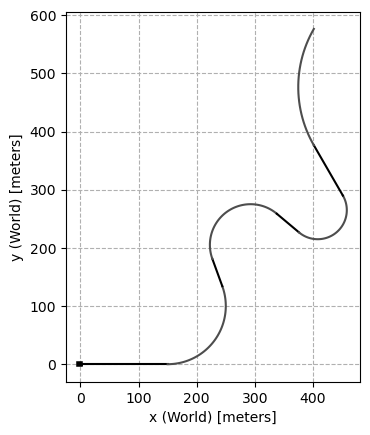

In [8]:
# load trained policy

model_name = "PPO_dr_wet_long_3"
model_idx = 250000
model_ppo = PPO.load(f"models/{model_name}/{model_idx}")

model_name = "SAC_dr_wet_long_6" # "SAC_dr_wet_long_6"
model_idx = 100000
model_sac = SAC.load(f"models/{model_name}/{model_idx}")

# Put the RL model into a policy class
rl_policy_ppo = RLPolicy(model_ppo)
rl_policy_sac = RLPolicy(model_sac)

path_for_saving_figures = f"models/{model_name}/eval"
ensure_dir(path_for_saving_figures)


# Create the evaluation environment with the fixed difficult road
eval_env = create_env(road_elements_list_eval_3, model="PPO")
# Render the road
eval_env.render_matplotlib_init_figure()
eval_env.render_matplotlib_plot_road()
plt.show()



Now starting simulation.
Simulation finished


PPO --> Simulation:

Saved figure: models/SAC_dr_wet_long_6/eval/ad_cartesian_coords_example.pdf
Saved figure: models/SAC_dr_wet_long_6/eval/ad_time_series_example.pdf
PPO --> Performance Metric dictionary:
{'average_dist_from_line': 0.17999192, 'std_dist': 0.119268276, 'max_dist': 0.9142793, 'avg_speed': 49.77371406555176, 'std_speed': 1.0348813176155092, 'max_speed': 64.48649139404297, 'min_speed': 49.146676254272464, 'max_exceedance_speed_limit': 0.0, 'fraction_time_above_speed_limit': 0.0, 'max_distance_from_line': 0.9142793, 'fraction_time_above_distance_from_line_threshold': 0.0, 'max_heading_angle_degrees': 4.060793348382701, 'average_heading_angle_deviation_degrees': 0.7081370977565556, 'total_variation_heading_angle': 12.979559, 'fraction_time_heading_angle_exceed_threshold': 0.04412354592860008, 'max_centripetal_acceleration_magnitude': 0.038444646, 'avg_centripetal_acceleration_magnitude': 0.02375218, 'relative_speed_at_tighte

/tmp/ipykernel_1164965/3493162967.py:73: RuntimeWarning: divide by zero encountered in divide
  road_radius_series = np.abs(1.0 / road_curvature_series)


Simulation finished


SAC --> Simulation:

Saved figure: models/SAC_dr_wet_long_6/eval/ad_cartesian_coords_example.pdf
Saved figure: models/SAC_dr_wet_long_6/eval/ad_time_series_example.pdf
SAC --> Performance Metric dictionary:
{'average_dist_from_line': 1.5509491, 'std_dist': 1.5569869, 'max_dist': 3.9637718, 'avg_speed': 33.63368911743164, 'std_speed': 9.65039234161377, 'max_speed': 64.48649139404297, 'min_speed': 21.202049446105956, 'max_exceedance_speed_limit': 0.0, 'fraction_time_above_speed_limit': 0.0, 'max_distance_from_line': 3.9637718, 'fraction_time_above_distance_from_line_threshold': 0.3355923014367037, 'max_heading_angle_degrees': 9.209010015465731, 'average_heading_angle_deviation_degrees': 0.6845821765475618, 'total_variation_heading_angle': 9.005812, 'fraction_time_heading_angle_exceed_threshold': 0.032800216860937925, 'max_centripetal_acceleration_magnitude': 0.03639418, 'avg_centripetal_acceleration_magnitude': 0.011725943, 'relative_speed_at_tightest_corner': 0.456

/tmp/ipykernel_1164965/3493162967.py:73: RuntimeWarning: divide by zero encountered in divide
  road_radius_series = np.abs(1.0 / road_curvature_series)


Simulation finished


PPO --> Simulation:

Saved figure: models/SAC_dr_wet_long_6/eval/ad_cartesian_coords_example.pdf
Saved figure: models/SAC_dr_wet_long_6/eval/ad_time_series_example.pdf
PPO --> Performance Metric dictionary:
{'average_dist_from_line': 0.23067495, 'std_dist': 0.17222416, 'max_dist': 0.90092736, 'avg_speed': 49.83650779724121, 'std_speed': 1.3343352556228638, 'max_speed': 64.48649139404297, 'min_speed': 48.99429931640625, 'max_exceedance_speed_limit': 0.0, 'fraction_time_above_speed_limit': 0.0, 'max_distance_from_line': 0.90092736, 'fraction_time_above_distance_from_line_threshold': 0.0, 'max_heading_angle_degrees': 5.240939046386892, 'average_heading_angle_deviation_degrees': 0.836065313611278, 'total_variation_heading_angle': 8.4686775, 'fraction_time_heading_angle_exceed_threshold': 0.09047292666209733, 'max_centripetal_acceleration_magnitude': 1.0212005, 'avg_centripetal_acceleration_magnitude': 0.62258196, 'relative_speed_at_tightest_corner': 0.499597915649414,

/tmp/ipykernel_1164965/3493162967.py:73: RuntimeWarning: divide by zero encountered in divide
  road_radius_series = np.abs(1.0 / road_curvature_series)


Simulation finished


SAC --> Simulation:

Saved figure: models/SAC_dr_wet_long_6/eval/ad_cartesian_coords_example.pdf
Saved figure: models/SAC_dr_wet_long_6/eval/ad_time_series_example.pdf
SAC --> Performance Metric dictionary:
{'average_dist_from_line': 2.8239295, 'std_dist': 1.708594, 'max_dist': 4.964991, 'avg_speed': 34.701687240600585, 'std_speed': 9.472895336151124, 'max_speed': 64.48649139404297, 'min_speed': 25.032322883605957, 'max_exceedance_speed_limit': 0.0, 'fraction_time_above_speed_limit': 0.0, 'max_distance_from_line': 4.964991, 'fraction_time_above_distance_from_line_threshold': 0.8021133525456292, 'max_heading_angle_degrees': 5.563546383246342, 'average_heading_angle_deviation_degrees': 1.0379938800071813, 'total_variation_heading_angle': 4.8030047, 'fraction_time_heading_angle_exceed_threshold': 0.13304514889529298, 'max_centripetal_acceleration_magnitude': 0.7049826, 'avg_centripetal_acceleration_magnitude': 0.31350058, 'relative_speed_at_tightest_corner': 0.298877

/tmp/ipykernel_1164965/3493162967.py:73: RuntimeWarning: divide by zero encountered in divide
  road_radius_series = np.abs(1.0 / road_curvature_series)


Simulation finished


PPO --> Simulation:

Saved figure: models/SAC_dr_wet_long_6/eval/ad_cartesian_coords_example.pdf
Saved figure: models/SAC_dr_wet_long_6/eval/ad_time_series_example.pdf
PPO --> Performance Metric dictionary:
{'average_dist_from_line': 0.32117984, 'std_dist': 0.2366782, 'max_dist': 0.9197765, 'avg_speed': 49.99759483337402, 'std_speed': 1.3787723779678345, 'max_speed': 64.48649139404297, 'min_speed': 49.26324119567871, 'max_exceedance_speed_limit': 0.0, 'fraction_time_above_speed_limit': 0.0, 'max_distance_from_line': 0.9197765, 'fraction_time_above_distance_from_line_threshold': 0.0, 'max_heading_angle_degrees': 3.7787748375528745, 'average_heading_angle_deviation_degrees': 0.8030234730885479, 'total_variation_heading_angle': 7.0976887, 'fraction_time_heading_angle_exceed_threshold': 0.05697589481373265, 'max_centripetal_acceleration_magnitude': 3.9805896, 'avg_centripetal_acceleration_magnitude': 1.5583112, 'relative_speed_at_tightest_corner': 0.4972291603088379, 

/tmp/ipykernel_1164965/3493162967.py:73: RuntimeWarning: divide by zero encountered in divide
  road_radius_series = np.abs(1.0 / road_curvature_series)


Simulation finished


SAC --> Simulation:

Saved figure: models/SAC_dr_wet_long_6/eval/ad_cartesian_coords_example.pdf
Saved figure: models/SAC_dr_wet_long_6/eval/ad_time_series_example.pdf
SAC --> Performance Metric dictionary:
{'average_dist_from_line': 1.4558105, 'std_dist': 0.7813793, 'max_dist': 3.6545722, 'avg_speed': 29.944895553588868, 'std_speed': 5.252772045135498, 'max_speed': 64.48649139404297, 'min_speed': 23.494367408752442, 'max_exceedance_speed_limit': 0.0, 'fraction_time_above_speed_limit': 0.0, 'max_distance_from_line': 3.6545722, 'fraction_time_above_distance_from_line_threshold': 0.7266666666666667, 'max_heading_angle_degrees': 11.103401401582849, 'average_heading_angle_deviation_degrees': 1.698314584292623, 'total_variation_heading_angle': 6.6810665, 'fraction_time_heading_angle_exceed_threshold': 0.304, 'max_centripetal_acceleration_magnitude': 1.7857437, 'avg_centripetal_acceleration_magnitude': 0.53634274, 'relative_speed_at_tightest_corner': 0.30110377120971676

/tmp/ipykernel_1164965/3493162967.py:73: RuntimeWarning: divide by zero encountered in divide
  road_radius_series = np.abs(1.0 / road_curvature_series)


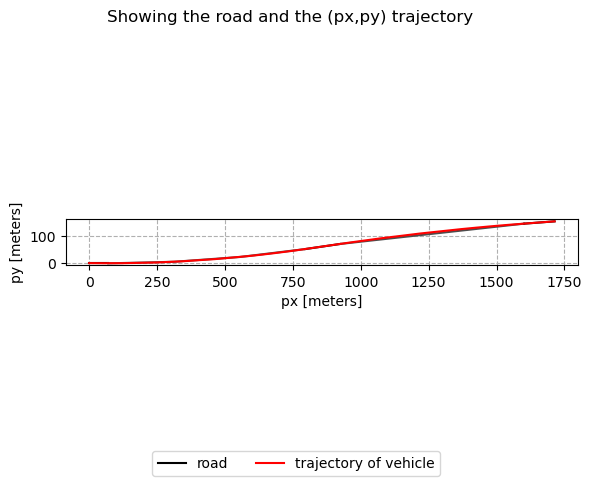

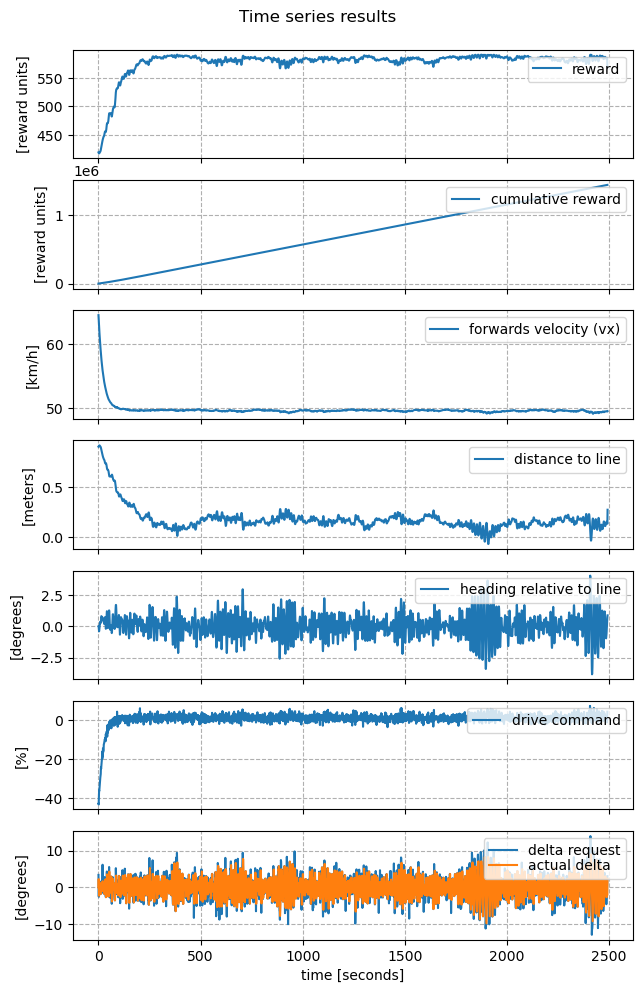

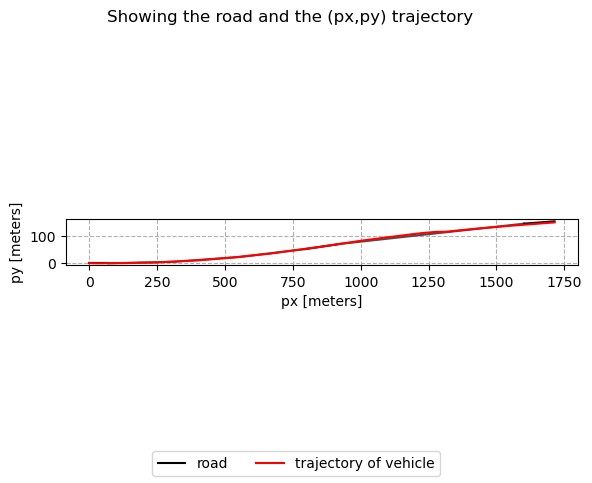

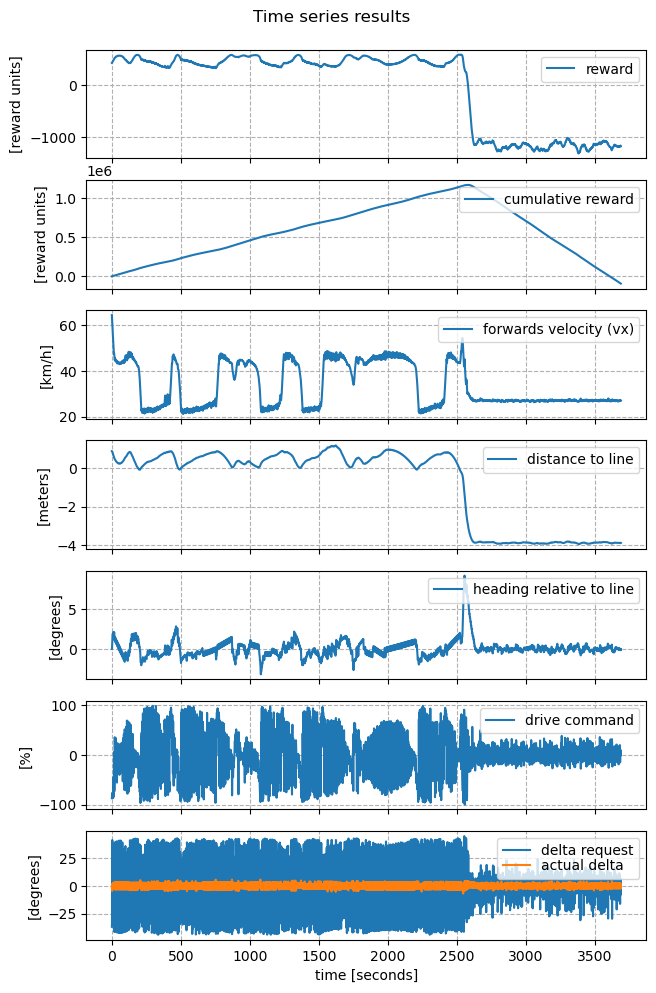

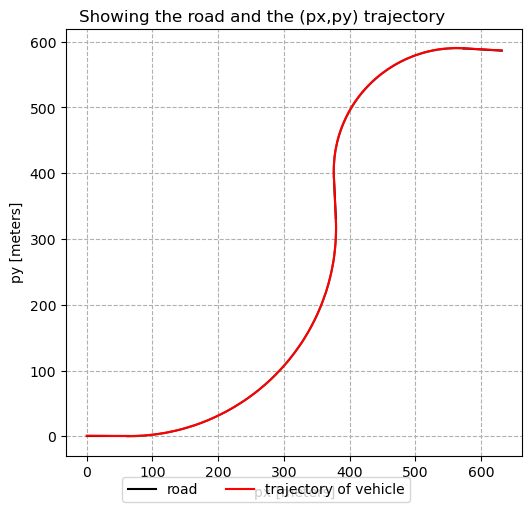

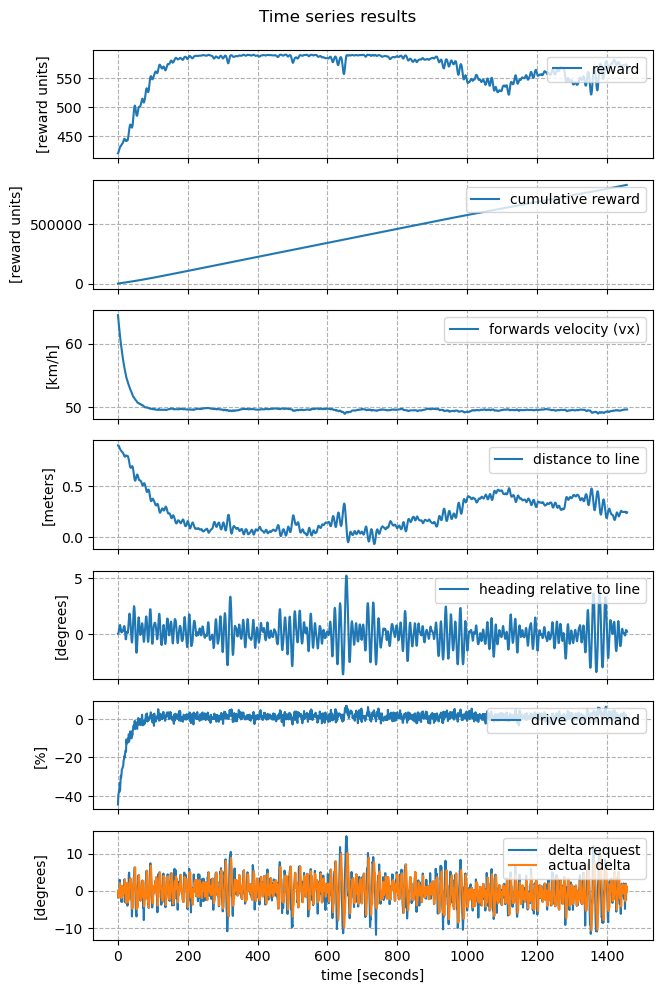

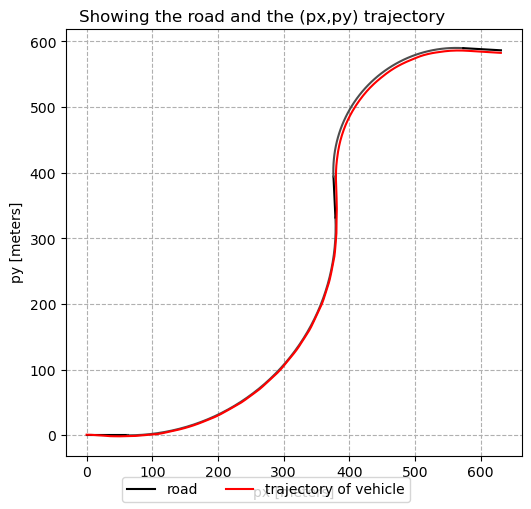

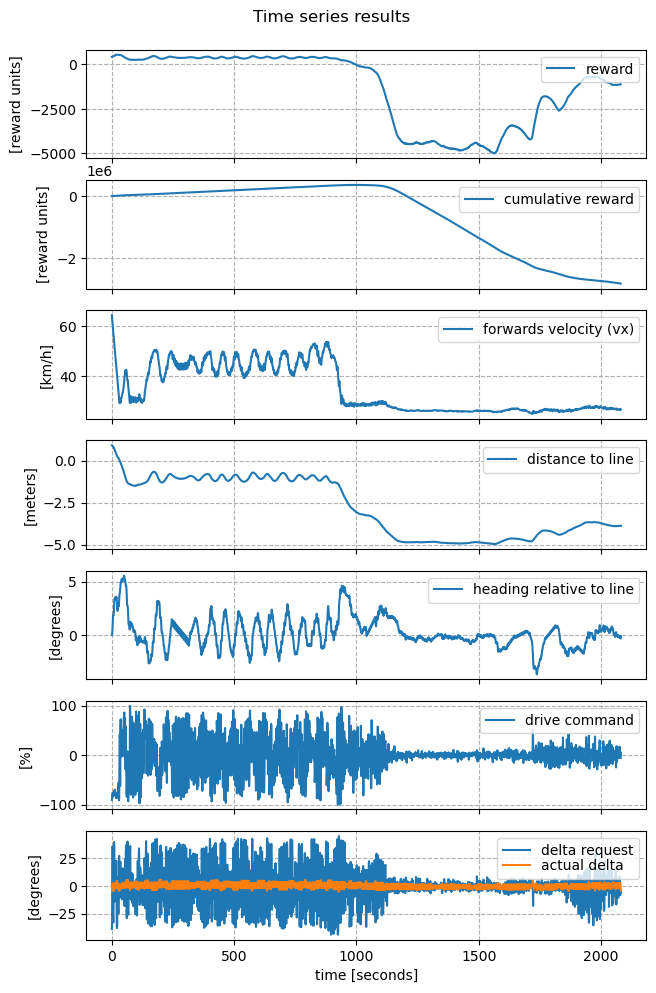

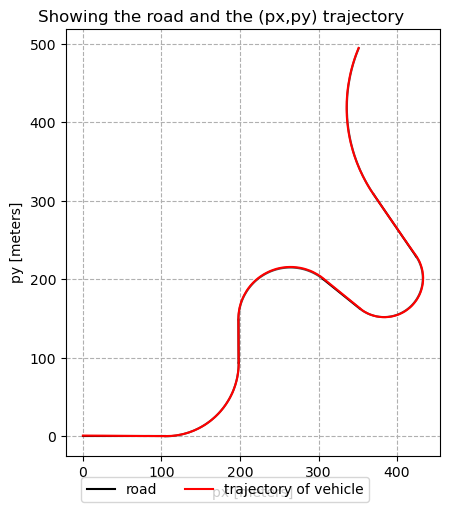

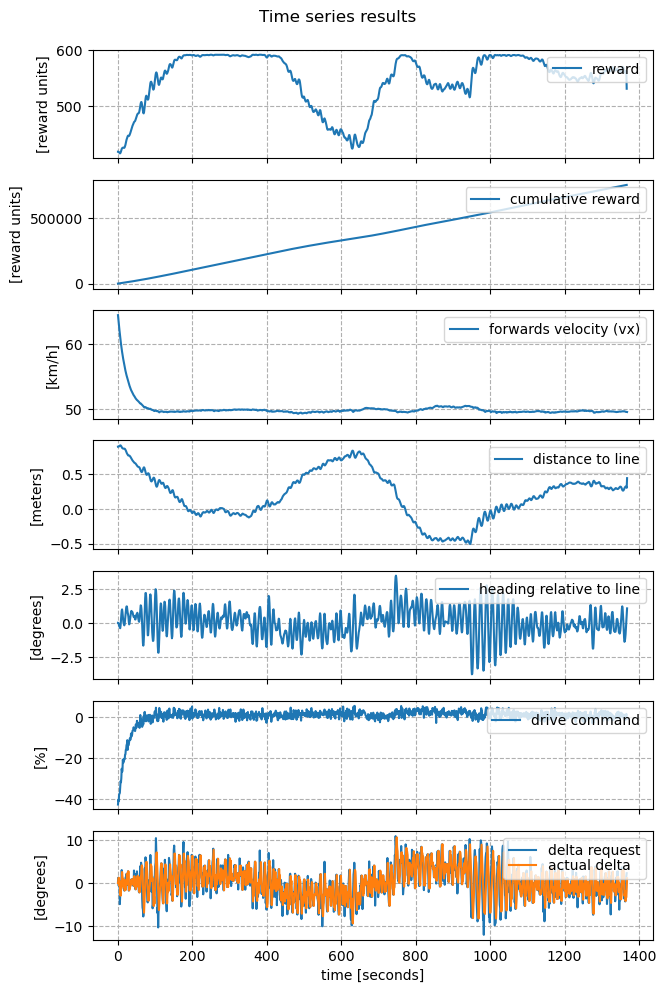

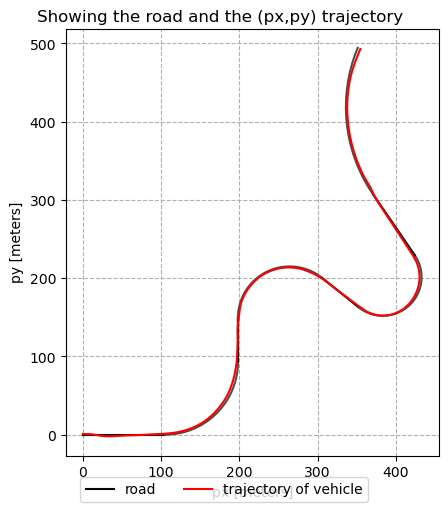

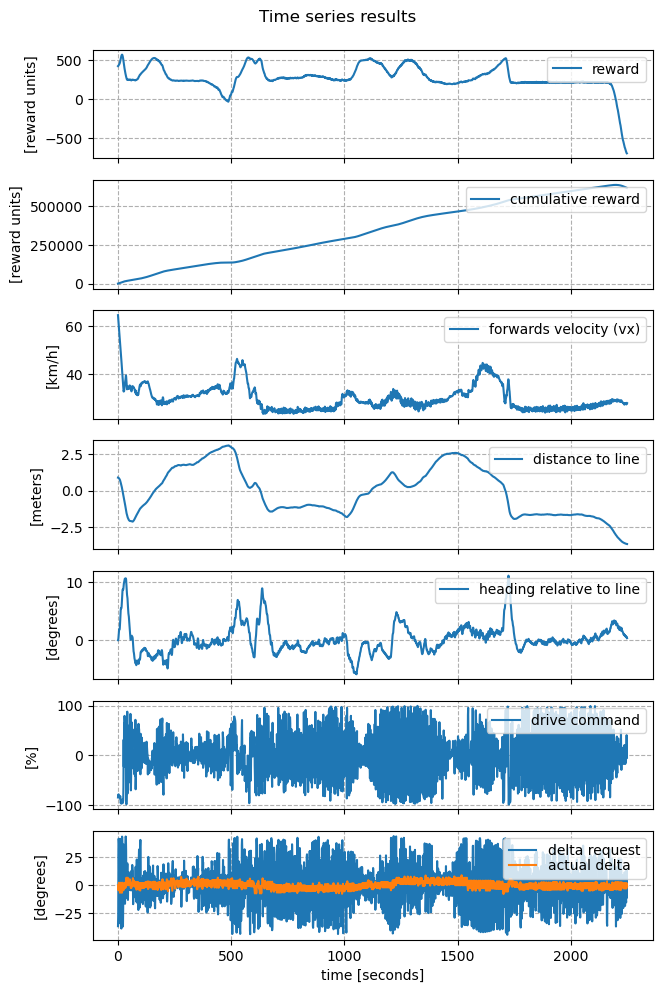

In [48]:
N_sim = 10000

# simulate for each of the 3 roads
#roads = [road_elements_list_eval_1, road_elements_list_eval_2, road_elements_list_eval_3]
roads = [road_perturbation_1(), road_perturbation_2(), road_perturbation_3()]


for road_elements_list in roads:
    # Create the evaluation environment with the fixed difficult road
    eval_env_ppo = create_env(road_elements_list, "PPO")
    eval_env_sac = create_env(road_elements_list, "SAC")
    
    # Specify the seed for when the simulate function resets the random number generator
    sim_seed = 1;
    
    # Call the function for simulating a given RL model
    sim_time_series_dict_ppo = simulate_policy(eval_env_ppo, N_sim, rl_policy_ppo, seed=sim_seed, verbose=1)
    file_name_suffix = "example"
    print("PPO --> Simulation:\n")
    plot_details_list = plot_results_from_time_series_dict(eval_env_ppo, sim_time_series_dict_ppo, path_for_saving_figures, file_name_suffix, should_plot_reward=True)

    # compute the performance metrics
    pm_dict_ppo = compute_performance_metrics_from_time_series(sim_time_series_dict_ppo)
    print("PPO --> Performance Metric dictionary:")
    print(pm_dict_ppo)

    # now do the same for the SAC model
    sim_time_series_dict_sac = simulate_policy(eval_env_sac, N_sim, rl_policy_sac, seed=sim_seed, verbose=1)
    file_name_suffix = "example"
    print("SAC --> Simulation:\n")
    plot_details_list = plot_results_from_time_series_dict(eval_env_sac, sim_time_series_dict_sac, path_for_saving_figures, file_name_suffix, should_plot_reward=True)

    # compute the performance metrics
    pm_dict_sac = compute_performance_metrics_from_time_series(sim_time_series_dict_sac)
    print("SAC --> Performance Metric dictionary:")
    print(pm_dict_sac)




### Computing Performance Metric aggregates over enviroment perturbations for evaluating robustness 

We will run a large number of simulations over perturbations of the following model parameters and uncertainties: 

1) variations in length and curvature of the road segments for each of the three road types
2) vehicle mass
3) variations in steering angle offset (i.e. delta_offset)



In [49]:
def performance_metrics_over_uncertainties(N_sim=10000, num_road_variations=2, road_type=3):
    # Initialise a list for all the performance metrics
    pm_per_sim_list_ppo = []
    pm_per_sim_list_sac = []

    # specify mass multiplier range
    mass_multiplier_range = np.arange(start=0.8, stop=1.2, step=0.05)    
    # specify delta offset range
    delta_offset_range = np.arange(start=-0.1, stop=0.1, step=0.02) 
   
    # Compute the number of simulation that will be performed
    num_sims_total = len(mass_multiplier_range) * len(delta_offset_range) * num_road_variations

    # Display a progress bar
    print("Now starting " + str(num_sims_total) + " simulations, this may take a while.")
    print("Progress indicator:")
    print("0%        50%       100%")
    print("|----|----|----|----|")
    print("|",end="")

    # Some variables for keeping track of the progress
    progress_inc = 0.05
    next_progress_print = progress_inc
    i_prog = 0

    # Initialise a seed for the random number generators
    sim_seed = 0

    # iterate over mass multipliers
    for mass_multiplier in mass_multiplier_range:
        # iterate over delta offset
        for delta_offset in delta_offset_range:
            # iterate over roads
            for i in range(num_road_variations):
                road_elements_list = create_road_perturbation(road_type)

                # Create an environment with the adjusted parameters
                eval_env_ppo = create_env(road_elements_list, "PPO", delta_offset_multiplier=delta_offset, mass_multiplier=mass_multiplier)
                eval_env_sac = create_env(road_elements_list, "SAC", delta_offset_multiplier=delta_offset, mass_multiplier=mass_multiplier)

                # Increment the seed
                sim_seed += 1
                
                # run simulation with PPO policy 
                sim_time_series_dict_ppo = simulate_policy(eval_env_ppo, N_sim, rl_policy_ppo, seed=sim_seed)
                # Compute the performance metrics for this simulation
                pm_dict_ppo = compute_performance_metrics_from_time_series(sim_time_series_dict_ppo)
                # Append to the list of all performance metrics
                pm_per_sim_list_ppo.append(pm_dict_ppo)

                # run simulation with SAC policy
                sim_time_series_dict_sac = simulate_policy(eval_env_sac, N_sim, rl_policy_sac, seed=sim_seed)
                # Compute the performance metrics for this simulation
                pm_dict_sac = compute_performance_metrics_from_time_series(sim_time_series_dict_sac)
                # Append to the list of all performance metrics
                pm_per_sim_list_sac.append(pm_dict_sac)

                # Print progress if necessary
                i_prog += 1
                if (i_prog >= (next_progress_print*num_sims_total)):
                    print("-",end="")
                    next_progress_print += progress_inc

    # Print the end of the progress bar 
    print("|")

    # Return the list of performance metrics per simulation
    return pm_per_sim_list_ppo, pm_per_sim_list_sac

In [50]:
pm_per_sim_list_ppo, pm_per_sim_list_sac = performance_metrics_over_uncertainties()

Now starting 160 simulations, this may take a while.
Progress indicator:
0%        50%       100%
|----|----|----|----|
|

/tmp/ipykernel_1164965/3493162967.py:73: RuntimeWarning: divide by zero encountered in divide
  road_radius_series = np.abs(1.0 / road_curvature_series)


-------------------|


In [53]:
# save the performance metrics to file
import pickle

with open("models/pm_per_sim_list_ppo.pkl", "wb") as f:
    pickle.dump(pm_per_sim_list_ppo, f)

with open("models/pm_per_sim_list_sac.pkl", "wb") as f:
    pickle.dump(pm_per_sim_list_sac, f)

In [54]:
metrics = ["max_exceedance_speed_limit", "fraction_time_above_speed_limit", "max_distance_from_line", "average_heading_angle_deviation_degrees", "total_variation_heading_angle", "max_centripetal_acceleration_magnitude", "avg_centripetal_acceleration_magnitude", "relative_speed_at_tightest_corner", "total_travel_time"]

metric_aggregates_ppo = {}
metric_aggregates_sac = {}

for metric in metrics:
    # compute the average and standard deviation of the performance metrics for the 3 policies
    metric_array_ppo = np.array([d[metric] for d in pm_per_sim_list_ppo])
    metric_array_sac = np.array([d[metric] for d in pm_per_sim_list_sac])

    average_metric_ppo = np.average(metric_array_ppo)
    average_metric_sac = np.average(metric_array_sac)

    std_metric_ppo = np.std(metric_array_ppo)
    std_metric_sac = np.std(metric_array_sac)


    metric_aggregates_ppo[metric] = {"average": average_metric_ppo, "std": std_metric_ppo}
    metric_aggregates_sac[metric] = {"average": average_metric_sac, "std": std_metric_sac}

# print the results in a table with 3 columns for the 3 policies
print("Performance Metric Aggregates:")
print("Metric".ljust(50) + "PPO".ljust(20) + "SAC".ljust(20))
print("-"*110)
for metric in metrics:
    print(metric.ljust(50) + "{:.2f} +/- {:.2f}".format(metric_aggregates_ppo[metric]["average"], metric_aggregates_ppo[metric]["std"]).ljust(20) + "{:.2f} +/- {:.2f}".format(metric_aggregates_sac[metric]["average"], metric_aggregates_sac[metric]["std"]).ljust(20))    


Performance Metric Aggregates:
Metric                                            PPO                 SAC                 
--------------------------------------------------------------------------------------------------------------
max_exceedance_speed_limit                        0.00 +/- 0.00       0.00 +/- 0.00       
fraction_time_above_speed_limit                   0.00 +/- 0.00       0.00 +/- 0.00       
max_distance_from_line                            0.89 +/- 0.13       4.13 +/- 0.67       
average_heading_angle_deviation_degrees           0.95 +/- 0.16       1.65 +/- 0.13       
total_variation_heading_angle                     8.74 +/- 1.09       6.89 +/- 0.58       
max_centripetal_acceleration_magnitude            3.95 +/- 0.25       1.79 +/- 0.11       
avg_centripetal_acceleration_magnitude            1.47 +/- 0.07       0.51 +/- 0.02       
relative_speed_at_tightest_corner                 0.50 +/- 0.00       0.30 +/- 0.01       
total_travel_time                      